## Проект 2: Симуляция для оценки мощности A/B-теста нового алгоритма рекомендаций


Был обновлен алгоритм рекомендаций: 

*   **Эффект алгоритма:** Добавляет пользователям 1-2 просмотра.
*   **Вероятность срабатывания:** 90%.
*   **Порог срабатывания:** Алгоритм не срабатывает, если у пользователя меньше 30 просмотров.


Основная гипотеза:

Обновление алгоритма рекомендаций также приведет к увеличению среднего количества лайков на пользователя. 

Задача: 

Оценить вероятность обнаружения статистически значимых отличий в среднем количестве лайков на пользователя между контрольной и экспериментальной группами на основе данных за две недели с 2024-09-20 по 2024-10-03 включительно. 

### Методология

Для решения задачи будет использоваться симуляция методом Монте-Карло. Этот метод выбран потому, что позволяет оценить мощность статистического теста (вероятность обнаружения эффекта, если он существует) при заданных параметрах эксперимента и распределениях данных, не проводя реальный эксперимент. Использование Монте-Карло особенно актуально, когда сложно точно предсказать распределение данных в реальном эксперименте, но есть возможность смоделировать его на основе исторических данных или на имеющихся данных из периода А/А-теста и А/B-теста.

### Процесс симуляции

1.  **Сбор и подготовка данных:**  Данные за две недели с 2024-09-20 по 2024-10-03 (период проведения А/А-теста и А/B-теста). Будут использоваться для построения распределения просмотров и лайков пользователей.
2.  **Разделение на группы:**  Пользователи будут разделены на две группы (контрольную и экспериментальную) в соотношении 50/50.
3.  **Симуляция эффекта алгоритма:**  Эффект алгоритма моделируется с учетом вероятности срабатывания (90%), добавления 1-2 просмотров, и порога срабатывания (30 просмотров).
4.  **Генерация симулированных данных:**  Для каждой симуляции генерируются данные о просмотрах и лайках для каждой группы пользователей.
5.  **Проведение статистического теста:**  Для каждой симуляции проводится t-тест с поправкой Уэлча на неравные дисперсии (`equal_var=False`). Поправка Уэлча используется, так как мы не можем предполагать, что дисперсии количества лайков в контрольной и экспериментальной группах будут равны. 
6.  **Оценка мощности:**  Мощность теста рассчитывается как доля симуляций, в которых t-тест показал статистически значимые различия (p-value < 0.05).
7.  **Повторение:** Шаги 3-6 повторяются не менее 20000 раз.


### Ожидаемые результаты

В результате симуляции будет получена оценка мощности теста – вероятность обнаружения статистически значимых различий в количестве лайков на пользователя между группами, если такие различия действительно существуют.


In [2]:
import pandas as pd
import pandahouse as ph
import numpy as np
from scipy import stats
from scipy.stats import norm, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm #шкала прогресса

rng = np.random.default_rng() #для генерации псевдослучайных чисел

In [15]:
#параметры соединения
connection = {'host': 'https://clickhouse.example',
            'database':'database',
            'user':'user',
            'password':'password'
            }

#CTR за период АА-теста и АВ-теста
q = """
    select 
       floor(ctr, 2) as ctr, count() as users
    from (select toDate(time) as dt,
        user_id,
        sum(action = 'like')/sum(action = 'view') as ctr
    from {db}.feed_actions
    where dt between '2024-09-20' and '2024-10-03' 
    group by dt, user_id
    )
    group by ctr
"""

#views за период АА-теста и АВ-теста
q2 = """
    select views, count() as users
    from (select  
        user_id,
        sum(action = 'view') as views
    from {db}.feed_actions
    where toDate(time) between '2024-09-20' and '2024-10-03'
    group by user_id
    )
    group by views
    order by views
"""

In [30]:
#эмпирическое распределение
views_distribution = ph.read_clickhouse(q2, connection=connection)
ctr_distribution = ph.read_clickhouse(q, connection=connection)
ctr_distribution['ctr'] = ctr_distribution['ctr'].fillna(0)
ctr_distribution['ctr'] = np.clip(ctr_distribution['ctr'], 0, 1)

In [31]:
#подсчет кол-ва пользователей за период
total_users = views_distribution.users.sum()

size = np.floor(total_users // 2)  # размер первой группы при разбивке 50/50 с округлением вниз

print(f"Размер выборки: {size}")

Размер выборки: 30591.0


In [32]:
#df с вероятностью просмотров 
views_distribution['p'] = views_distribution['users']/views_distribution.users.sum()
views_distribution.sort_values(by = 'p', ascending = False)

#df с вероятностью ctr 
ctr_distribution['p'] = ctr_distribution['users']/ctr_distribution.users.sum()
ctr_distribution.sort_values(by = 'p', ascending = False)

,ctr,users,p
21,0.20,9970,0.054944
57,0.25,8514,0.046920
39,0.16,8344,0.045983
6,0.18,8228,0.045344
84,0.21,7756,0.042742
...,...,...,...
70,0.74,1,0.000006
9,0.91,1,0.000006
59,1.00,1,0.000006
58,0.95,1,0.000006


<Axes: ylabel='Count'>

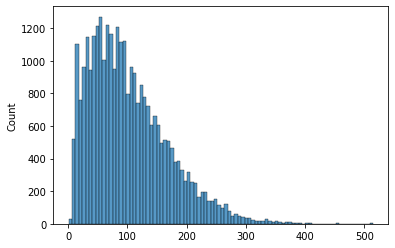

In [33]:
#генерируем распределение просмотров на основе реальных данных
sim_views = rng.choice(a=views_distribution.views, size=30591, replace=True, p=views_distribution.p)
sns.histplot(sim_views)

<Axes: ylabel='Count'>

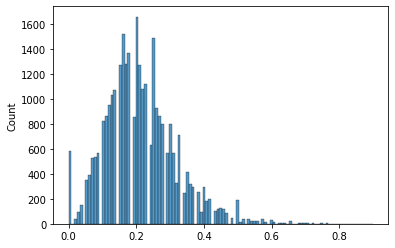

In [34]:
#генерируем распределение ctr на основе реальных данных
sim_ctrs = rng.choice(a=ctr_distribution.ctr, size=30591, replace=True, p=ctr_distribution.p)
sns.histplot(sim_ctrs)

<Axes: ylabel='Count'>

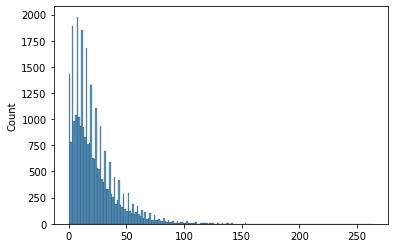

In [35]:
#симуляция распределения лайки-клики на основе реальных данных - np.random.binomial с количеством испытаний, равным количеству просмотров, и вероятностью успеха, равной CTR
#т.о. используется два фактора, чтобы смоделировать лайки/клики: кол-во просмотров влияет на шанс получить лайк/клик, также чем выше CTR, тем больше шансов получить лайк или клик
sim_clicks = rng.binomial(n=sim_views.astype("int64"), p=sim_ctrs)
sns.histplot(sim_clicks)

### Моделирование эффекта нового алгоритма на просмотры

Для имитации эффекта нового алгоритма, добавляющего пользователям 1 или 2 просмотра с вероятностью 90% (при условии, что у пользователя более 30 просмотров), используется следующее выражение:

***group_B_views + ((1 + rng.binomial(n=1, p=0.5, size=размер_выборки)) * rng.binomial(n=1, p=0.9, size=размер_выборки) * (group_B_views >= 30))***

**Разберем формулу:**

*   **`group_B_views`**: Это массив, содержащий исходное количество просмотров для каждого пользователя в экспериментальной группе (группа B). К этому массиву добавляется имитация эффекта алгоритма.

*   **(1 + `rng.binomial(n=1, p=0.5, size=размер_выборки)`)**: Эта часть отвечает за добавление 1 или 2 просмотров.
    *   `rng.binomial(n=1, p=0.5, size=размер_выборки)` генерирует массив случайных чисел 0 и 1, где вероятность 0 и 1 равна 0.5. Это моделирует “бросок монетки”.
    *   Прибавление 1 к результату биномиального распределения (0 или 1) дает либо 1, либо 2. Таким образом, мы получаем массив, где каждому пользователю соответствует число 1 или 2, отражающее количество дополнительных просмотров.

*   **`rng.binomial(n=1, p=0.9, size=размер_выборки)`**: Эта часть моделирует вероятность срабатывания алгоритма.
    *   `rng.binomial(n=1, p=0.9, size=размер_выборки)` генерирует массив случайных чисел 0 и 1. Вероятность 1 (алгоритм сработал) равна 0.9, а вероятность 0 (алгоритм не сработал) равна 0.1.

*   **`(group_B_views >= 30)`**: Это булевое условие, которое определяет, будет ли применен эффект алгоритма к пользователю.
    *   Для каждого пользователя проверяется, больше ли количество его просмотров (`group_B_views`) 30.
    *   Результат — булевый массив (`True` или `False`), который при поэлементном умножении на числовой массив интерпретируется как 1 (`True`) или 0 (`False`).

    
Как все работает вместе:

1.  Начинаем с исходного количества просмотров (`group_B_views`).
2.  Генерируем массив, определяющий, сколько дополнительных просмотров добавить каждому пользователю (1 или 2).
3.  Генерируем массив, определяющий, сработал ли алгоритм для каждого пользователя (1 или 0).
4.  Используем условие `(group_B_views >= 30)`, чтобы применить эффект только к пользователям с достаточным количеством просмотров.
5.  Все эти массивы перемножаются поэлементно, а затем складываются с исходным количеством просмотров, моделируя финальное количество просмотров после действия алгоритма.

В итоге, это выражение моделирует увеличение просмотров у экспериментальной группы в соответствии с заданными условиями: 1-2 просмотра с вероятностью 90% для пользователей с 30 и более просмотрами.

In [36]:
#создаем последовательность из 1 и 2
1 + rng.binomial(n=1, p=0.5, size=30591)
#создаем последовательность из 0 и 1 
rng.binomial(n=1, p=0.9, size=30591)
#пользователи с числом просмотров большим, чем 30
sim_views >= 30

array([ True,  True,  True, ...,  True, False,  True])

In [37]:
#при перемножении получим массив из 0,1,2: 0 - пользователи без просмотров и/или 10%, 1 - один просмотр, 2 - два просмотра
rng.binomial(n=1, p=0.9, size=30591) * (1 + rng.binomial(n=1, p=0.5, size=30591)) * (sim_views >= 30)

array([2, 1, 1, ..., 0, 0, 2])

In [38]:
#добавим к нашим просмотрам и получим эффект, на этой основе будем генерировать лайки
sim_views + (rng.binomial(n=1, p=0.9, size=30591) * (1 + rng.binomial(n=1, p=0.5, size=30591)) * (sim_views >= 30))

array([112., 132., 233., ...,  66.,  20.,  66.])

In [39]:
#расчет мощности
def power_calc(sample_size, views_df, ctr_df, threshold, nsim=1000):


    pvalues = [] #список для p-value
    rng = np.random.default_rng()

    #симуляируем просмотры, ctr, эффект, лайки, сравниваем t-тестом nsim раз:
    for _ in tqdm(range(nsim)):

        group_A_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")
        group_B_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")

        group_B_views = group_B_views + (rng.binomial(n=1, p=0.9, size=sample_size) * (1 + rng.binomial(n=1, p=0.5, size=sample_size)) * (group_B_views >= threshold))
        group_B_views = group_B_views.astype("int64")

        group_A_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)
        group_B_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)

        clicks_A = rng.binomial(n=group_A_views, p=group_A_ctr)
        clicks_B = rng.binomial(n=group_B_views, p=group_B_ctr)

        pvalues.append(ttest_ind(clicks_A, clicks_B, equal_var=False).pvalue)

    #получаем мощность
    return np.mean(np.array(pvalues) < 0.05)

In [40]:
power_calc(sample_size=30591, views_df=views_distribution, ctr_df=ctr_distribution, threshold=30, nsim=20000)

100%|██████████| 20000/20000 [06:23<00:00, 52.17it/s]


0.36525

### Анализ результатов симуляции

В результате симуляции методом Монте-Карло была получена статистическая мощность 36%. Это значение значительно ниже общепринятого стандарта в 80%. На первый взгляд, это может показаться неожиданным, учитывая большой размер выборки (по 30591 пользователя в каждой группе), что обычно ассоциируется с высокой статистической мощностью.

Однако, низкая мощность объясняется несколькими факторами:

*   **Малый эффект алгоритма:** Алгоритм добавляет всего 1-2 просмотра, что может быть недостаточно для обнаружения статистически значимого влияния на среднее количество лайков, особенно при наличии значительной дисперсии данных.

*   **Порог срабатывания алгоритма:** Алгоритм применяется только к пользователям с количеством просмотров ≥ 30, что уменьшает число пользователей, на которых воздействует алгоритм, и, следовательно, уменьшает мощность теста.

*   **Вероятность срабатывания алгоритма:** 90% вероятность срабатывания алгоритма уменьшают размер выборки, на которую влияет алгоритм.

Эти факторы влияют на дисперсию данных и затрудняют обнаружение относительно малого эффекта алгоритма.

Для повышения статистической мощности и более точной оценки эффекта алгоритма предлагается следующий подход:

*   **Анализ подвыборки:**  Вместо анализа полной выборки,  будет использована подвыборка, включающая только пользователей с количеством просмотров ≥ 30.  Это позволит исключить "шум" от пользователей, на которых алгоритм не оказывает никакого влияния. Несмотря на потенциальное снижение общего размера выборки, ожидается *повышение* мощности теста. Это происходит потому, что фильтрация пользователей  приведет к уменьшению дисперсии данных в экспериментальной и контрольной группах,  что, в свою очередь, увеличит статистическую значимость различий между группами, если таковые действительно есть.  В результате,  даже при меньшем числе наблюдений, мы можем получить более высокую мощность за счет повышения "сигнала" (различия между группами) по отношению к "шуму" (дисперсии данных).

Дальнейший анализ будет проведен с использованием подвыборки для проверки, подтвердится ли предположение о повышении мощности теста.

In [42]:
#расчет мощности
def power_calc_filtered(sample_size, views_df, ctr_df, threshold, nsim=1000):


    pvalues = [] #список для p-value
    rng = np.random.default_rng()

    #симуляируем просмотры, ctr, эффект, лайки, сравниваем t-тестом nsim раз:
    for _ in tqdm(range(nsim)):

        group_A_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")
        group_B_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")

        group_B_views = group_B_views + (rng.binomial(n=1, p=0.9, size=sample_size) * (1 + rng.binomial(n=1, p=0.5, size=sample_size)) * (group_B_views >= threshold))
        group_B_views = group_B_views.astype("int64")

        #отсеиваем лишних 
        filter_A = group_A_views>=threshold
        filter_B = group_B_views>=threshold
        
        group_A_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)
        group_B_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)

        clicks_A = rng.binomial(n=group_A_views, p=group_A_ctr)
        clicks_B = rng.binomial(n=group_B_views, p=group_B_ctr)

        pvalues.append(ttest_ind(clicks_A[filter_A], clicks_B[filter_B], equal_var=False).pvalue)

    #получаем мощность
    return np.mean(np.array(pvalues) < 0.05)

In [43]:
power_calc_filtered(sample_size=30591, views_df=views_distribution, ctr_df=ctr_distribution, threshold=30, nsim=20000)

100%|██████████| 20000/20000 [06:26<00:00, 51.69it/s]


0.40085

## Вывод

Несмотря на предпринятую попытку повысить мощность, используя подвыборку пользователей, достичь приемлемого уровня статистической мощности не удалось. Вместо ожидаемых 80% в результате симуляции по подвыборке получили 40%. Хотя это и демонстрирует некоторое увеличение по сравнению с исходными 36%, всё ещё не позволяет нам с уверенностью утверждать, что мы сможем зафиксировать эффект от внедрения алгоритма, если он будет.

В сложившихся обстоятельствах, когда потенциал выявить эффект нового алгоритма остается ограниченным, следует взвесить ряд возможных стратегий:

*   **Возможный отказ от эксперимента:** В ситуации, когда выделенных ресурсов не достаточно для обнаружения столь малого изменения, можно рассмотреть отказ от проведения эксперимента, тем самым избежав риска получить неинформативные результаты.
*  **Уточнение объема выборки:** Вернуться к эксперименту позднее. Буть может удастся добрать данных для целей достижения требуемой мощности.
*   **Пересмотр уровня значимости:** В качестве варианта можно рассмотреть увеличение уровня значимости (например, до 0.1). Это способно увеличить мощность теста, однако, это повысит риск получения ложноположительных результатов (ошибки второго рода).
*   **Альтернативные статистические тесты:** Можно провести сравнение и заменить t-тест на другой статистический метод, который лучше адаптирован к данной ситуации. 
*   **Методы снижения изменчивости метрики:** Попробовать снизить вариативность в данных, например при помощи CUPED (Controlled-experiment Using Pre-Existing Data). Это могло бы увеличить чувствительность теста и снизить дисперсию, что упростило бы выявление изменений. 
*   **Поиск способов усиления воздействия алгоритма:** Необходимо оценить возможности модификации алгоритма, чтобы увеличить его результативность. Например, расширить охват пользователей, на которых он влияет, либо же усилить сам эффект, повысив количество дополнительных просмотров.

**Заключительный комментарий:**

Принимая во внимание недостаточную мощность исследования, нужно тщательно оценить каждый из предложенных путей. Окончательное решение о дальнейших действиях должно базироваться на оценке имеющихся ресурсов, возможных рисках и полном понимании ограничений текущей модели. Кроме того, важно помнить о том, что статистическая значимость не должна восприниматься как гарантия наличия реального эффекта.